# pyod examples

# pyod examples

`-` ref: https://pyod.readthedocs.io/en/latest/example.html

# knn_example

In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys

In [2]:
# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize


On Training Data:
KNN ROC:0.9992, precision @ rank n:0.95

On Test Data:
KNN ROC:1.0, precision @ rank n:1.0

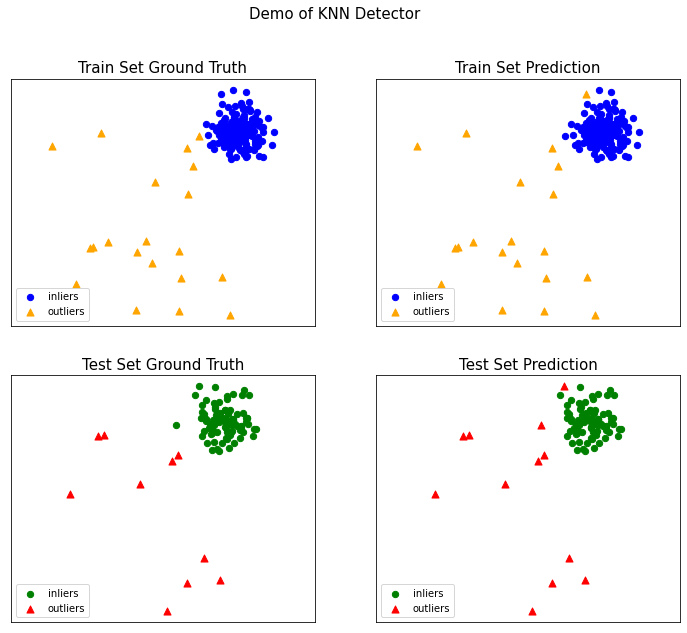

In [6]:

if __name__ == "__main__":
    contamination = 0.1  # 이상치 비율
    n_train = 200  
    n_test = 100  

    # Generate sample data
    X_train, X_test, y_train, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train kNN detector
    clf_name = 'KNN'
    clf = KNN()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # 이상치 점수

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=True)

# comb_example

Example of combining multiple base outlier scores. Four combination
frameworks are demonstrated:

1.  **Average**: take the average of all base detectors
2.  **maximization** : take the maximum score across all detectors as
    the score
3.  **Average of Maximum (AOM)**
4.  **Maximum of Average (MOA)**

위 4개의 프레임워크를 사용하여 KNN 이상치 감지 모델 평가

In [9]:
from __future__ import division
from __future__ import print_function

import os
import sys

In [10]:
# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.knn import KNN
from pyod.models.combination import aom, moa, average, maximization, median
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print


In [15]:

if __name__ == "__main__":

    # Define data file and read X and y
    # Generate some data if the source data is missing
    mat_file = 'cardio.mat'
    try:
        mat = loadmat(os.path.join('data', mat_file))

    except TypeError:
        print('{data_file} does not exist. Use generated data'.format(
            data_file=mat_file))
        X, y = generate_data(train_only=True)  # load data
    except IOError:   # 존재하지 않을 때 .. 
        print('{data_file} does not exist. Use generated data'.format(
            data_file=mat_file))
        X, y = generate_data(train_only=True)  # load data
    else:
        X = mat['X']
        y = mat['y'].ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    # standardizing data for processing
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    n_clf = 20  # number of base detectors 이상치 초기화

    # Initialize 20 base detectors for combination
    k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,
              150, 160, 170, 180, 190, 200]

    train_scores = np.zeros([X_train.shape[0], n_clf])   # 훈련 데이터의 행 수
    test_scores = np.zeros([X_test.shape[0], n_clf])

    print('Combining {n_clf} kNN detectors'.format(n_clf=n_clf))

    for i in range(n_clf):
        k = k_list[i]

        clf = KNN(n_neighbors=k, method='largest')
        clf.fit(X_train_norm)

        train_scores[:, i] = clf.decision_scores_
        test_scores[:, i] = clf.decision_function(X_test_norm)

    # Decision scores have to be normalized before combination
    train_scores_norm, test_scores_norm = standardizer(train_scores,
                                                       test_scores)
    # Combination by average
    y_by_average = average(test_scores_norm)
    evaluate_print('Combination by Average', y_test, y_by_average)

    # Combination by max
    y_by_maximization = maximization(test_scores_norm)
    evaluate_print('Combination by Maximization', y_test, y_by_maximization)

    # Combination by median
    y_by_median = median(test_scores_norm)
    evaluate_print('Combination by Median', y_test, y_by_median)

    # Combination by aom
    y_by_aom = aom(test_scores_norm, n_buckets=5)
    evaluate_print('Combination by AOM', y_test, y_by_aom)

    # Combination by moa
    y_by_moa = moa(test_scores_norm, n_buckets=5)
    evaluate_print('Combination by MOA', y_test, y_by_moa)

cardio.mat does not exist. Use generated data
Combining 20 kNN detectors
Combination by Average ROC:0.0, precision @ rank n:0.0
Combination by Maximization ROC:0.0055, precision @ rank n:0.0
Combination by Median ROC:0.0, precision @ rank n:0.0
Combination by AOM ROC:0.0055, precision @ rank n:0.0
Combination by MOA ROC:0.0083, precision @ rank n:0.0

`-` 참고(홈페이지에서 나온 결과값)

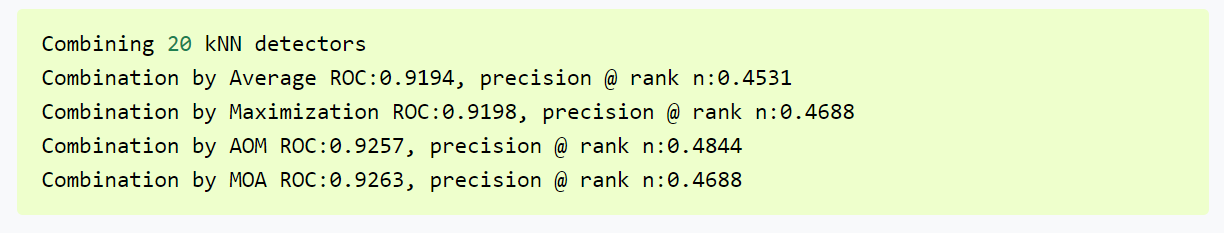

# Thresholding Example

Example of using Angle-base outlier detection (ABOD) for outlier
detection

In [30]:
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from pyod.models.kde import KDE
from pyod.models.thresholds import FILTER
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.thresholds import FILTER
from pyod.models.kde import FILTER



On Training Data:
KDE ROC:0.9992, precision @ rank n:0.95

On Test Data:
KDE ROC:1.0, precision @ rank n:1.0

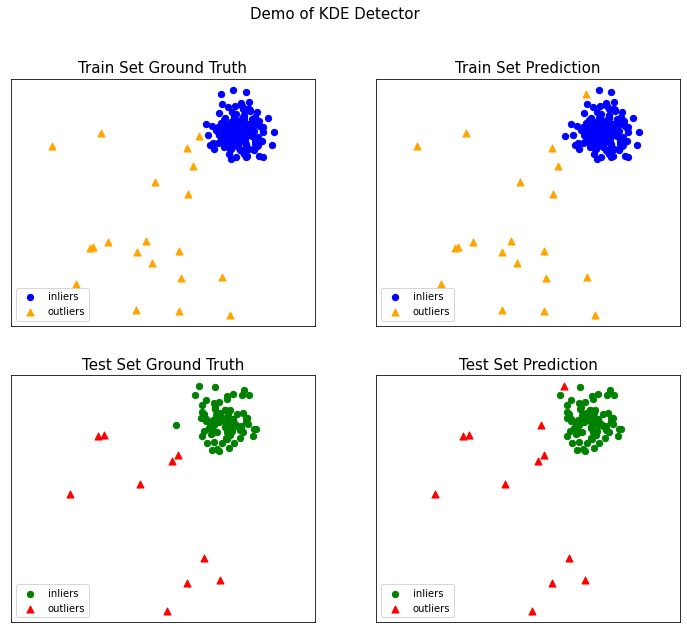

In [31]:
if __name__ == "__main__":
    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    X_train, X_test, y_train, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train KDE detector
    clf_name = 'KDE'
    #clf = KDE(contamination=FILTER()) 안됨
    clf = KDE(contamination=contamination)
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=False)

`-` ref:https://slowsteadystat.tistory.com/25

In [5]:
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.pca import PCA
from pyod.models.iforest import IForest

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

python outlier detection

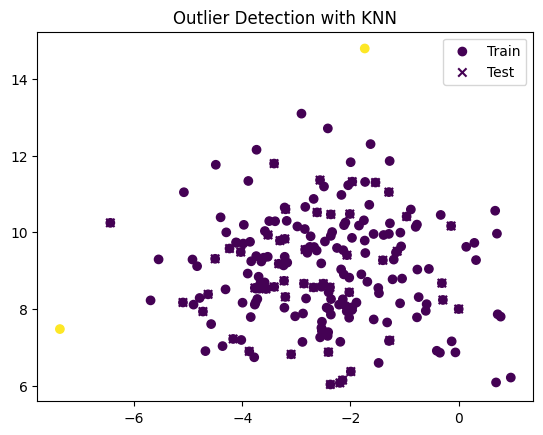

In [11]:
import numpy as np
from pyod.models.knn import KNN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# 가상의 데이터 생성
X_train, _ = make_blobs(n_samples=200, n_features=2, centers=1, cluster_std=1.5, random_state=42)
X_test, _ = make_blobs(n_samples=50, n_features=2, centers=1, cluster_std=1.5, random_state=42)

# 이상치 추가
X_train[-1] = np.array([0, 8])
X_test[-1] = np.array([0, 8])

# KNN 모델 초기화
model = KNN(contamination=0.01)  # contamination은 이상치 비율을 나타냅니다.

# 모델 훈련
model.fit(X_train)

# 이상치 감지
y_train_pred = model.labels_  # 0은 정상, 1은 이상치를 나타냅니다.
y_test_pred = model.predict(X_test)

# 결과 시각화
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train_pred, marker='o', label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred, marker='x', label='Test')
plt.title('Outlier Detection with KNN')
plt.legend()
plt.show()
